In [1]:
import copy
import os
import random
from enum import Enum

import cv2 as cv
import cv2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# About the project

*This project will seek to discover if machine learning models can train on two different datasets
and still deliver acceptable results. The two datasets in question are MNIST and SVHN,
both datasets containing numbers. The MNIST dataset contains handwritten digits of a single color,
whereas SVHN contains house numbers in different shapes and colors. We will use a siamese model to see
if the model can learn features despite its differences in numerical shapes. In addition, we will
use a model with two identical networks in parallel, without weight sharing, where each network will
have it's own dataset of focus.*

# Startphase
*Before we set up the models and the training we must familiarize with the datasets used.*

## Loading the MNIST dataset
*The MNIST dataset is available through the torchvision package*

In [2]:
mnist_train_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=True)
mnist_test_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Loading the SVHN dataset
*The SVHN dataset is also available through torchvision. However, it has a different logic for splitting into train, test and extra*

In [3]:
svhn_train_dataset = torchvision.datasets.SVHN(root="data", split='extra', download=True, transform=ToTensor())
svhn_test_dataset = torchvision.datasets.SVHN(root="data", split='test', download=True, transform=ToTensor())


  0%|          | 0/1329278602 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

## Visualizing the MNIST dataset
*As seen below, the MNIST dataset is pretty simple and contains a fairly unanimous representation*

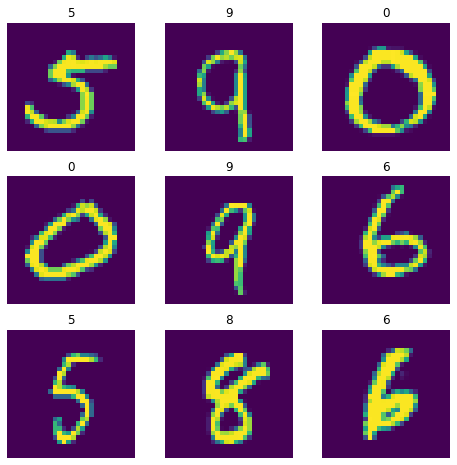

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(mnist_train_dataset), size=(1,)).item()
    img, label = mnist_train_dataset[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Visualizing the SVHN dataset
*The SVHN dataset differs from the MNIST dataset in several ways. Some images are nearly impossible to interpret,
some contains several digits, and all of them are colored. To bridge the gap between these two datasets we will explore
some image processing techniques that may help us. Here we are visualising the "extra" split, as this will be used in
training due to it's clearer images.

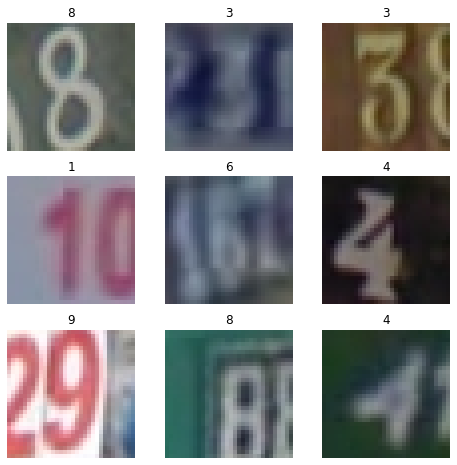

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(svhn_train_dataset), size=(1,)).item()
    img, label = svhn_train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    ax1 = figure.add_subplot(rows, cols, i)
    ax1.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

## Creating 2d-array with all the tensors based on label

In [6]:
num_classes = len(mnist_train_dataset.classes)

mnist_idx_by_class = [np.where(mnist_train_dataset.targets == i)[0] for i in range(0, num_classes)]
mnist_idx_test_by_class = [np.where(mnist_test_dataset.targets == i)[0] for i in range(0, num_classes)]

svhn_idx_by_class = [np.where(svhn_train_dataset.labels == i)[0] for i in range(0, num_classes)]
svhn_idx_test_by_class = [np.where(svhn_test_dataset.labels == i)[0] for i in range(0, num_classes)]

## Inspecting same label images from the two datasets
*Here we can see the difference between the datasets, compared on the same number*

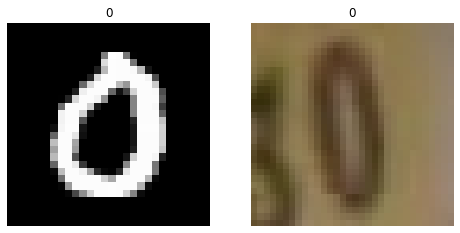

In [7]:
random_class = np.random.randint(0, num_classes)

mnist_idx = random.choice(mnist_idx_by_class[random_class])
svhn_idx = random.choice(svhn_idx_by_class[random_class])

figure = plt.figure(figsize=(8, 8))
mnist_img = mnist_train_dataset.data[mnist_idx]
svhn_img = svhn_train_dataset.data[svhn_idx]

ax = figure.add_subplot(1, 2, 1)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(mnist_img.squeeze(), cmap="gray")
ax = figure.add_subplot(1, 2, 2)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(svhn_img.transpose(1, 2, 0))

plt.show()



# Rewrite this based on what we end up using
## Visualizing the distribution of labels from both train splits
*As we can see the SVHN contains more images in total compared to the MNIST dataset. The distribution between the different
classes is also quite uneven. To overcome this we will reduce the amount of images per class to 6k.
The MNIST dataset generally has a quite even distribution of the digits and has a total of 60k images on the train split.
We will do no modification to this dataset*


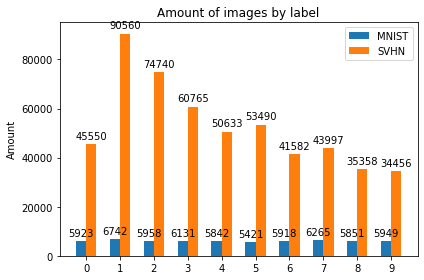

In [8]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_by_class]
len_svhn = [len(x) for x in svhn_idx_by_class]

width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Visualizing the distribution of labels from both test splits
*We can see that the distribution between the test splits are also quite uneven. To handle this
we will reduce the number of test images in SVHN to 1k.*

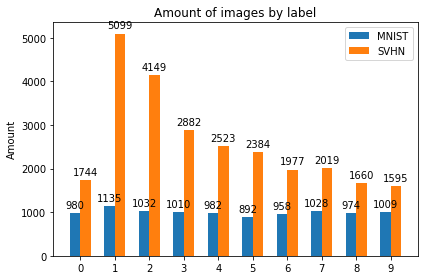

In [9]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_test_by_class]
len_svhn = [len(x) for x in svhn_idx_test_by_class]

width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


# Data preprocessing - Exploration phase
*As we determined above, there is quite some difference between the datasets. In this section we will
try to do some preprocessing to bridge the gap between the two*

## Grayscale
*We will start by applying grayscale as this makes the image go from 3 channel to 1 channel. This is necessary as
the MNIST images is already 1 channel.*

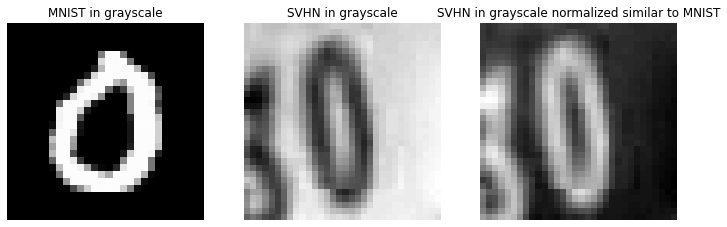

In [10]:
gray_svhn = T.Grayscale()(torch.from_numpy(svhn_img))

gray_svhn2 = gray_svhn

gray_svhn = torch.movedim(gray_svhn, 0, 2)

gray_svhn2 = gray_svhn2.detach().numpy()
gray_svhn2 = cv.normalize(gray_svhn2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
gray_svhn2 = 255 - gray_svhn2

figure = plt.figure(figsize=(12, 8))
ax = figure.add_subplot(1, 3, 1)
plt.axis("off")
ax.set_title("MNIST in grayscale")
plt.imshow(mnist_img.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 3, 2)
plt.axis("off")
ax.set_title("SVHN in grayscale")
plt.imshow(gray_svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 3, 3)
plt.axis("off")
ax.set_title("SVHN in grayscale normalized similar to MNIST")
plt.imshow(gray_svhn2.squeeze(), cmap="gray")

plt.show()


## Threshold
*Another technique we will try is thresholding the image. By doing this we will get a output image only
consisting of black and white. As we can see below, the threshold delivers some questionable results. Although
it is able to deliver only black and white, it still adds noise to the image.*

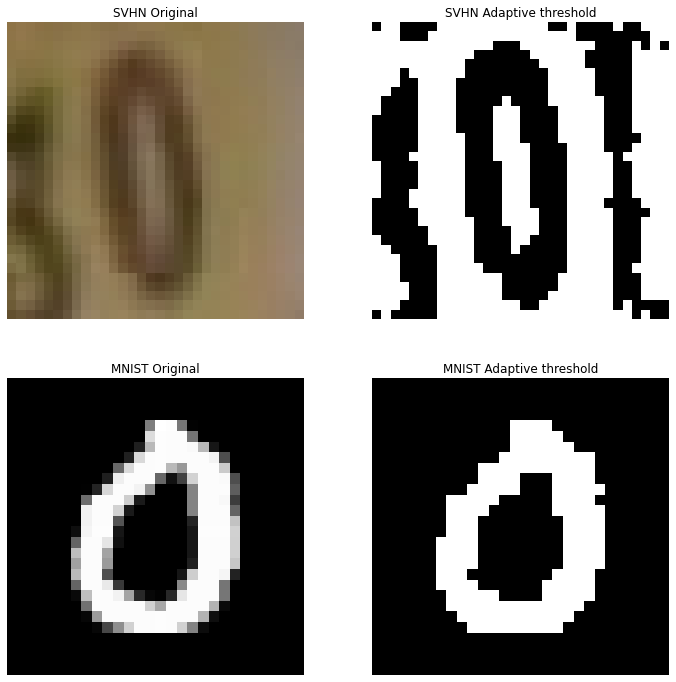

In [11]:
svhn = svhn_img.transpose(1, 2, 0)
mnist = mnist_img.detach().numpy()

svhn_grey = cv.cvtColor(svhn, cv.COLOR_BGR2GRAY)
svhn_grey = cv.normalize(svhn_grey, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
svhn_grey = svhn_grey.astype(np.uint8)

#Should find a good number for reduction on adaptive threshold, e.g. the last number
svhn_threshold = cv.adaptiveThreshold(svhn_grey, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)
#svhn_threshold = cv.bitwise_not(svhn_threshold)

#Threshold reduction number needs to be 0 on mnist
mnist = cv.normalize(mnist, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
mnist = mnist.astype(np.uint8)
mnist_threshold = cv.adaptiveThreshold(mnist, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(12, 12))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("SVHN Original")
plt.axis("off")
plt.imshow(svhn, cmap="gray")

ax = figure.add_subplot(2, 2, 2)
ax.set_title("SVHN Adaptive threshold")
plt.axis("off")
plt.imshow(svhn_threshold, cmap="gray")

ax = figure.add_subplot(2, 2, 3)
ax.set_title("MNIST Original")
plt.axis("off")
plt.imshow(mnist, cmap="gray")

ax = figure.add_subplot(2, 2, 4)
ax.set_title("MNIST Adaptive threshold")
plt.axis("off")
plt.imshow(mnist_threshold, cmap="gray")

plt.show()

## Equalize Hist and CLAHE
*Last we will try equalize histogram and CLAHE + grayscale. We will first convert the images into grayscale
before applying the different techniques, leaving us with a 1 channel image.*

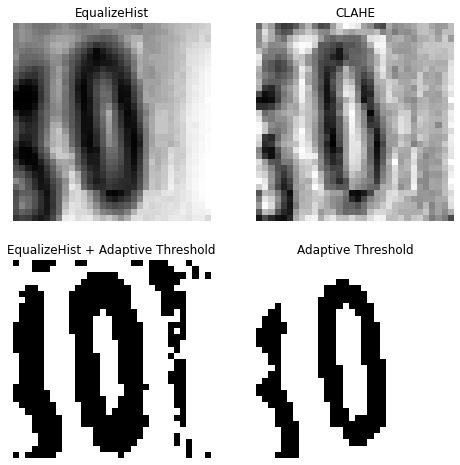

In [12]:
image = svhn

image = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = image.astype(np.uint8)

image2 = image
image4 = image

image = cv.equalizeHist(image)
clahe = cv.createCLAHE(clipLimit=3., )
image2 = clahe.apply(image2)

image3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
image4 = cv.adaptiveThreshold(image4, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 20)

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("EqualizeHist")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 2)
ax.set_title("CLAHE")
plt.axis("off")
plt.imshow(image2.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 3)
ax.set_title("EqualizeHist + Adaptive Threshold")
plt.axis("off")
plt.imshow(image3.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 4)
ax.set_title("Adaptive Threshold")
plt.axis("off")
plt.imshow(image4.squeeze(), cmap="gray")


## Clearing up variables
*Upon ending the exploration we will empty some variables to reduce the load as much as possible*


In [13]:
del svhn_idx_by_class
del svhn_train_dataset
del mnist_idx_by_class
del mnist_train_dataset

# Defining the model
*Let's start with defining the different models that will be used for the training*

### Using CUDA if possible

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Defining the loss function
*The loss function used in this project is a contrastive loss. When two images is similar, the loss will
be low and high when the images are dissimilar. The margin in the loss function sets the limit for how
the distance of dissimilar images will be. If the distance is greater than the margin, the loss is set to zero
because the representations are already far enough apart. If the distance is less than the margin,
the loss is set to the difference between the distance and the margin, encouraging the network to
push the representations farther apart.*

In [15]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)

        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + label
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        ) / 2.0
        return loss_contrastive


def threshold_contrastive_loss(output1: torch.Tensor, output2: torch.Tensor, m: float):
    """dist > m --> 1 else 0"""
    euclidean_distance = F.pairwise_distance(output1, output2)
    threshold = euclidean_distance.clone()
    threshold.data.fill_(m)
    return (euclidean_distance > threshold).float()


## Transformations
*We define the transformations that we want to use on our images*

In [16]:
class ToNumpy:
    def __call__(self, sample):
        if len(sample.shape) == 2:
            sample = sample.unsqueeze(0)

        if isinstance(sample, torch.Tensor):
            sample = sample.numpy()
        return sample.transpose(1, 2, 0)


class Resize:
    def __call__(self, sample):
        return cv2.resize(sample, (28, 28))


class GrayScale:
    def __call__(self, sample):
        if len(sample.shape) < 3:
            return sample
        return cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)


class EqualizeHist:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        sample = cv.equalizeHist(sample)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample
        return sample


class CLAHE:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        clahe = cv.createCLAHE(clipLimit=3., )
        sample = clahe.apply(sample)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample
        return sample


class AdaptiveThreshold:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        sample = cv.adaptiveThreshold(sample, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 10)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample

        return sample


## Defining siamese network model
*Our model is based on the resnet architecture. We have slightly modified it to fit our needs of images
with only 1 channel instead of 3 channel*

In [17]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = torchvision.models.resnet18(pretrained=False)
        self.fc_in_features = self.cnn1.fc.in_features

        self.cnn1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn1 = nn.Sequential(*(list(self.cnn1.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


## Non-siamese model
*Our non-siamese model is also based on the resnet18 architecture. Instead of using the same network
for both forward passes, we have two separate resnet18 networks for each input. One network will always handle input
from one dataset, and the other network will always handle the data from the remaining dataset.  We design the non-siamese
dataset such that MNIST input always will be the first and SVHN always will be second.*

In [18]:
class NonSiameseNetwork(nn.Module):
    def __init__(self):
        super(NonSiameseNetwork, self).__init__()

        #By design of the dataset input 1 will always be mnist and input 2 will always be svhn

        self.cnn1 = torchvision.models.resnet18(pretrained=False)
        self.fc_in_features = self.cnn1.fc.in_features
        self.cnn1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn1 = nn.Sequential(*(list(self.cnn1.children())[:-1]))

        self.cnn2 = torchvision.models.resnet18(pretrained=False)
        self.cnn2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn2 = nn.Sequential(*(list(self.cnn2.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward_second(self, x):
        output = self.cnn2(x)
        output = output.view(output.size()[0], -1)
        output = self.fc2(output)
        return output

    def forward(self, input1, input2):
        # forward pass of mnist input
        output1 = self.forward_once(input1)
        # forward pass of svhn input
        output2 = self.forward_second(input2)
        return output1, output2


# Setting up the custom datasets


## The four possible dataset combinations

In [19]:
class DatasetType(Enum):
    MNIST = 1,  #Only the MNIST dataset
    SVHN = 2,  #Only the SVHN dataset
    BOTH = 3,  #SVHN images will be paired with SVHN and MNIST images with MNIST
    MIX = 4  #SVHN and MNIST will be paired and mixed at random

## Siamese dataset
*The siamese dataset can be mixed based on the enum. It will preprocess the whole dataset based on
the transformation before creating the pairs. The pairs are created with both negative and positive samples,
meaning that we will have some pair of images where they are from the same class and some images
where the images are from different classes.*

In [20]:
class SiameseDataset(Dataset):
    def __init__(self, train: bool, dataset_type: DatasetType, transform=None):
        self.dataset_type = dataset_type
        self.transform = transform
        self.train = train

        # Numbers 0 to 9 as a total of 10 classes
        self.num_classes = 10

        # Unless the dataset is set to only SVHN we include the MNIST
        if self.dataset_type != DatasetType.SVHN:
            self.mnist = torchvision.datasets.MNIST("files", train=train, download=True)
            print("Preprocessing MNIST")
            self.mnist_preprocessed = list(map(self.transform, self.mnist.data))
            print("MNIST preprocessed")

        # Unless the dataset is set to only MNIST we include the SVHN
        if self.dataset_type != DatasetType.MNIST:
            self.svhn = torchvision.datasets.SVHN(root="data", split="extra" if train else "test", download=True)
            print("Preprocessing SVHN")
            self.svhn_preprocessed = list(map(self.transform, self.svhn.data))
            print("SVHN preprocessed")

        self.pairs = self.make_pairs()

    def __getitem__(self, index):
        img1_dataset, img1_index, img2_dataset, img2_index, matching = self.pairs[index]

        img1 = self.mnist_preprocessed[img1_index] if (img1_dataset == 0) else self.svhn_preprocessed[img1_index]
        img2 = self.mnist_preprocessed[img2_index] if (img2_dataset == 0) else self.svhn_preprocessed[img2_index]

        return img1, img2, matching

    def __len__(self):
        return len(self.pairs)

    def make_pairs(self):
        """
            Generating index pairs from images within the datasets.
            For each image one positive and one negative image pair is generated.
            If type is set to MIX it mixes pairs between MNIST and SVHN.
            If type is set to BOTH it uses images between MNIST and SVHN separately.
            If type is set to SVHN it uses only SVHN dataset.
            If type is set to MNIST it uses only MNIST dataset.
        """
        pairs = []

        if self.dataset_type == DatasetType.MNIST or self.dataset_type == DatasetType.BOTH:
            mnist_by_label = [np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)]

            for label in range(len(mnist_by_label)):
                for anchor_image in mnist_by_label[label]:

                    pos_image = np.random.choice(mnist_by_label[label])
                    pairs.append([0, anchor_image, 0, pos_image, 0])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(mnist_by_label[neg_label])
                    pairs.append([0, anchor_image, 0, neg_image, 1])

        if self.dataset_type == DatasetType.SVHN or self.dataset_type == DatasetType.BOTH:
            svhn_by_label = [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]
            for i in range(0, self.num_classes):
                limit = 6000 if self.train is True else 1000
                svhn_by_label[i] = svhn_by_label[i][0:limit]

            for label in range(len(svhn_by_label)):
                for anchor_image in svhn_by_label[label]:

                    pos_image = np.random.choice(svhn_by_label[label])

                    pairs.append([1, anchor_image, 1, pos_image, 0])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(svhn_by_label[neg_label])

                    pairs.append([1, anchor_image, 1, neg_image, 1])

        if self.dataset_type == DatasetType.MIX:
            datasets_by_label = [[np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)],
                                 [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]]
            for i in range(0, len(datasets_by_label[1])):
                limit = 6000 if self.train is True else 1000
                datasets_by_label[1][i] = datasets_by_label[1][i][0:limit]

            for dataset_index in range(len(datasets_by_label)):
                dataset_by_label = datasets_by_label[dataset_index]

                for label in range(len(dataset_by_label)):
                    for anchor_image in dataset_by_label[label]:

                        pos_dataset_index = np.random.randint(0, 2)
                        pos_image = np.random.choice(datasets_by_label[pos_dataset_index][label])

                        pairs.append([dataset_index, anchor_image, pos_dataset_index, pos_image, 0])

                        neg_dataset_index = np.random.randint(0, 2)
                        neg_label = np.random.randint(0, self.num_classes)
                        while neg_label == label:
                            neg_label = np.random.randint(0, self.num_classes)

                        neg_image = np.random.choice(datasets_by_label[neg_dataset_index][neg_label])

                        pairs.append([dataset_index, anchor_image, neg_dataset_index, neg_image, 1])

        return pairs

## Non-Siamese dataset
*The non-siamese will be preprocessed similarly to the siamese dataset. The pairs are created
in such a way that it will always be a MNIST image as the first image and a SVHN image in the second*

In [21]:
class NonSiameseDataset(Dataset):
    def __init__(self, train: bool, dataset_type: DatasetType, transform=None):
        self.transform = transform
        self.train = train

        # Numbers 0 to 9 as a total of 10 classes
        self.num_classes = 10

        self.mnist = torchvision.datasets.MNIST("files", train=train, download=True)
        print("Preprocessing MNIST")
        self.mnist_preprocessed = list(map(self.transform, self.mnist.data))
        print("MNIST preprocessed")

        self.svhn = torchvision.datasets.SVHN(root="data", split="extra" if train else "test", download=True)
        print("Preprocessing SVHN")
        self.svhn_preprocessed = list(map(self.transform, self.svhn.data))
        print("SVHN preprocessed")

        self.pairs = self.make_pairs()

    def __getitem__(self, index):
        img1_index, img2_index, matching = self.pairs[index]

        img1 = self.mnist_preprocessed[img1_index]
        img2 = self.svhn_preprocessed[img2_index]

        return img1, img2, matching

    def __len__(self):
        return len(self.pairs)

    def make_pairs(self):
        """
            Generating index pairs from images within the datasets.
            For each image one positive and one negative image pair is generated.
        """
        pairs = []
        datasets_by_label = [[np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)],
                             [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]]

        for i in range(0, len(datasets_by_label[1])):
            limit = 6000 if self.train is True else 1000
            datasets_by_label[1][i] = datasets_by_label[1][i][0:6000]

        for dataset_index in range(len(datasets_by_label)):
            dataset_by_label = datasets_by_label[dataset_index]

            for label in range(len(dataset_by_label)):
                for anchor_image in dataset_by_label[label]:

                    other_dataset = abs(dataset_index - 1)
                    pos_image = np.random.choice(datasets_by_label[other_dataset][label])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(datasets_by_label[other_dataset][neg_label])

                    if dataset_index == 0:
                        pairs.append([anchor_image, pos_image, 0])
                        pairs.append([anchor_image, neg_image, 1])
                    else:
                        pairs.append([pos_image, anchor_image, 0])
                        pairs.append([neg_label, anchor_image, 1])

        return pairs

## Train logic

In [22]:
def reset_weights(m):
    """
    Try resetting model weights to avoid
    weight leakage. Experienced this when using k-fold
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()


def train(model, optimizer, criterion, dataloader, device):
    model.train()

    # If image pair has distance above this value they are considered as dissimilar
    binary_threshold = 1.

    loss = []
    correct = 0
    total = 0.
    for img1, img2, label in dataloader:
        optimizer.zero_grad()

        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)

        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())

        output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
        total += len(label)
        correct += (output_label == label).sum().item()

    loss = np.array(loss)
    return loss.mean() / len(dataloader), correct / total


def save_model(model, name):
    model.eval()
    # Input to the model
    example1 = torch.randn(1, 1, 28, 28)
    example2 = torch.randn(1, 1, 28, 28)
    traced_script_module = torch.jit.trace(model.cpu(), (example1, example2))
    torch.jit.save(traced_script_module, name)
    print(f"Saved model with name: {name}")


def validate(model, criterion, dataloader, device):
    model.eval()

    # If image pair has distance above this value they are considered as dissimilar
    binary_threshold = 1.

    loss = []
    correct = 0
    total = 0.
    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)

            loss_contrastive = criterion(output1, output2, label)
            loss.append(loss_contrastive.item())

            output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
            total += len(label)
            correct += (output_label == label).sum().item()

        loss = np.array(loss)
    return loss.mean() / len(dataloader), correct / total


def train_pipeline(epochs, k_fold, batch_size, train_dataset, lr, device, num_workers, model):
    contrastive_loss = ContrastiveLoss()
    best_model = ""

    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

        # Creating val loader and train loader based on current fold split
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler,
                                      num_workers=num_workers)
        val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler,
                                    num_workers=num_workers)

        net = model()
        net.apply(reset_weights)
        net = net.to(device)

        adam = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)

        rounds_without_improvement = 0
        best_loss = float('inf')
        best_epoch = 0

        print(f"--FOLD {fold + 1}--\n")
        for epoch in range(epochs):
            print(f"--EPOCH {epoch + 1}--")

            train_loss, train_acc = train(model=net, optimizer=adam, criterion=contrastive_loss, device=device,
                                          dataloader=train_dataloader)
            print(f"Train loss {train_loss:.5f}, Train acc {train_acc:.5f}")

            val_loss, val_acc = validate(model=net, criterion=contrastive_loss, device=device,
                                         dataloader=val_dataloader)
            print(f"Val loss {val_loss:.5f}, Val acc {val_acc:.5f}")

            # Saving best model so far
            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch
                best_model = copy.deepcopy(net)
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1

            # Early stopping if model cease to improve
            if rounds_without_improvement > 3:
                break

        save_model(model=best_model,
                   name=f"fold{fold + 1}-epoch{best_epoch + 1}-transforms{random.randint(0, 10000)}.pt")

    return best_model

## Test logic

In [23]:
def test_pipeline(test_dataset, num_workers, model, batch_size, device):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Load from disk based on the model name
    if isinstance(model, str):
        model = torch.jit.load(f"{model}.pt")
    model = model.to(device)

    # Array that keeps track on euclidean distance based on true label
    res = [[], []]
    count = 1

    # Classify images as different if above this value
    binary_threshold = 1.

    # Keeping track num of correct predictions and total predictions
    correct = 0
    total = 0.

    with torch.no_grad():
        for img1, img2, label in test_dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Generating output for current batch
            output1, output2 = model(img1, img2)

            # Generating similar/dissimilar predictions based on output and distance threshold
            output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)

            total += len(label)
            correct += (output_label == label).sum().item()

            # Add distance to collection based on true label between the images
            for i in range(len(output1)):
                res[label[i]].append(F.pairwise_distance(output1[i], output2[i]).item())

            # Plot test examples and display distance and true label
            if count < 10:
                figure = plt.figure(figsize=(4, 4))
                figure.suptitle(f'Image no.{count}', fontsize=16)

                ax = figure.add_subplot(1, 2, 1)
                ax.set_title("Img1")
                plt.axis("off")
                plt.imshow(img1[0].cpu().squeeze(), cmap="gray")
                ax = figure.add_subplot(1, 2, 2)
                ax.set_title("Img2")
                plt.axis("off")
                plt.imshow(img2[0].cpu().squeeze(), cmap="gray")

                plt.show()

                print(f"Image no.{count}")
                if label[0].cpu() == torch.FloatTensor([[0]]):
                    caption = "Same numbers"
                else:
                    caption = "Different numbers"

                print(f"Correct label: '{caption}'")
                print(F.pairwise_distance(output1[0], output2[0]).item())
                print()

            count += 1

        # Print mean and standard deviation based on distance from the different categories
        print("\nImages with same number")
        print(f"Mean: {torch.mean(torch.tensor(res[0]))}")
        print(f"Std: {torch.std(torch.tensor(res[0]))}\n")

        print("Images with different number")
        print(f"Mean: {torch.mean(torch.tensor(res[1]))}")
        print(f"Std: {torch.std(torch.tensor(res[1]))}\n")

        print(f"Accuracy {correct / total}")
        fig = plt.figure(1, figsize=(9, 6))
        ax = fig.add_subplot(111)
        ax.boxplot(res)
        plt.show()

# Experiments

*We will conduct two main experiments, with two different preprocessing in both. In the first part,
we will use a siamese model and the siamese dataset. We will try all 4 different combinations of the dataset
with both preprocessing. In the second part we will use the non-siamese model and dataset with both preprocessings.*

In [24]:
class Pipelines:
    def __init__(self, k_fold_splits, batch_size, lr, epochs, transform, device, num_workers, siamese: bool):
        self.k_fold = KFold(n_splits=k_fold_splits, shuffle=True)
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.transform = transform
        self.device = device
        self.num_workers = num_workers

        if siamese:
            self.dataset = SiameseDataset
            self.model = SiameseNetwork
        else:
            self.dataset = NonSiameseDataset
            self.model = NonSiameseNetwork

    def mnist_svhn_mix_pipeline(self):
        print("Starting mnist-svhn-mix pipeline")

        train_dataset = self.dataset(train=True, dataset_type=DatasetType.MIX, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=self.device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.MIX, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def mnist_svhn_pipeline(self):
        print("Starting mnist-svhn pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.BOTH, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.BOTH, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def mnist_pipeline(self):
        print("Starting mnist pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.MNIST, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.MNIST, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def svhn_pipeline(self):
        print("Starting svhn pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.SVHN, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.SVHN, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def all_pipelines(self):
        self.mnist_svhn_mix_pipeline()
        self.mnist_svhn_pipeline()
        self.mnist_pipeline()
        self.svhn_pipeline()


Running config 1 pipeline
Starting mnist-svhn-mix pipeline


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw

Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00109, Train acc 0.86738
Val loss 0.00208, Val acc 0.94890
--EPOCH 2--
Train loss 0.00035, Train acc 0.96366
Val loss 0.00132, Val acc 0.96408
--EPOCH 3--
Train loss 0.00028, Train acc 0.96967
Val loss 0.00139, Val acc 0.95848
--EPOCH 4--
Train loss 0.00025, Train acc 0.97278
Val loss 0.00144, Val acc 0.95885
--EPOCH 5--
Train loss 0.00024, Train acc 0.97439
Val loss 0.00128, Val acc 0.96375
--EPOCH 6--
Train loss 0.00022, Train acc 0.97581
Val loss 0.00128, Val acc 0.96204
--EPOCH 7--
Train loss 0.00022, Train acc 0.97630
Val loss 0.00130, Val acc 0.96337
--EPOCH 8--
Train loss 0.00021, Train acc 0.97715
Val loss 0.00142, Val acc 0.95942
--EPOCH 9--
Train loss 0.00021, Train acc 0.97696
Val loss 0.00106, Val acc 0.96950
--EPOCH 10--
Train loss 0.

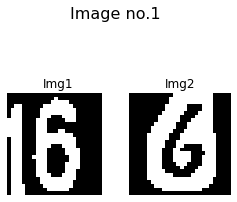

Image no.1
Correct label: 'Same numbers'
0.02141023799777031



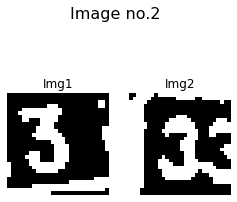

Image no.2
Correct label: 'Same numbers'
0.07557713240385056



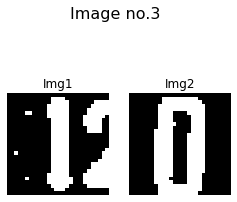

Image no.3
Correct label: 'Same numbers'
0.013744700700044632



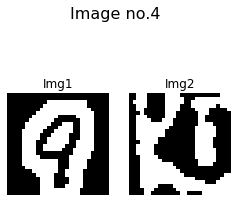

Image no.4
Correct label: 'Different numbers'
2.761216402053833



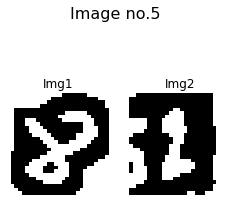

Image no.5
Correct label: 'Different numbers'
1.8324908018112183



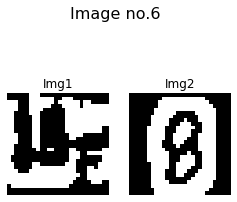

Image no.6
Correct label: 'Same numbers'
1.8441725969314575



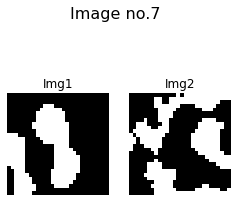

Image no.7
Correct label: 'Different numbers'
1.758789300918579



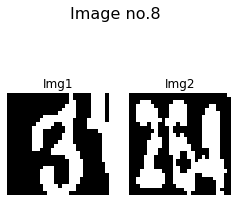

Image no.8
Correct label: 'Different numbers'
2.025999069213867



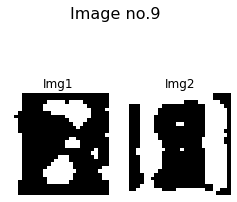

Image no.9
Correct label: 'Same numbers'
1.1401652097702026


Images with same number
Mean: 0.28781864047050476
Std: 0.5274360775947571

Images with different number
Mean: 1.9958146810531616
Std: 0.3962337374687195

Accuracy 0.933275


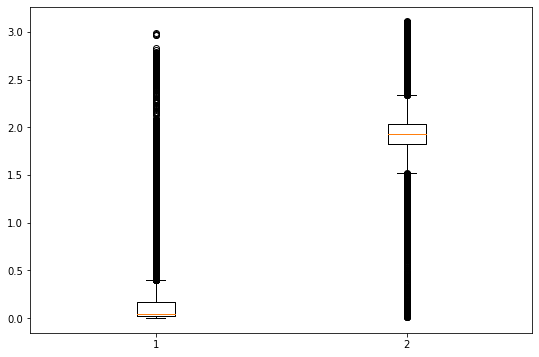

Starting mnist-svhn pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00093, Train acc 0.88946
Val loss 0.00175, Val acc 0.95644
--EPOCH 2--
Train loss 0.00034, Train acc 0.96337
Val loss 0.00156, Val acc 0.95973
--EPOCH 3--
Train loss 0.00028, Train acc 0.96966
Val loss 0.00138, Val acc 0.96206
--EPOCH 4--
Train loss 0.00026, Train acc 0.97180
Val loss 0.00143, Val acc 0.96000
--EPOCH 5--
Train loss 0.00025, Train acc 0.97285
Val loss 0.00136, Val acc 0.95948
--EPOCH 6--
Train loss 0.00023, Train acc 0.97472
Val loss 0.00112, Val acc 0.96815
--EPOCH 7--
Train loss 0.00022, Train acc 0.97559
Val loss 0.00128, Val acc 0.96435
--EPOCH 8--
Train loss 0.00021, Train acc 0.97640
Val loss 0.00117, Val acc 0.96685
--EPOCH 9--
Train loss 0.00021, Train acc 0.97674
Val loss 0.00125, Val acc 0.96392
--EPOCH 10--
Train loss 0.00020, Train acc 0.97737
Val loss 0.00103, V

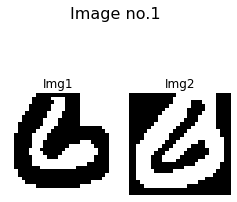

Image no.1
Correct label: 'Same numbers'
0.09802223742008209



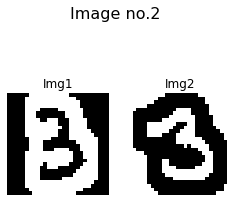

Image no.2
Correct label: 'Same numbers'
0.051439035683870316



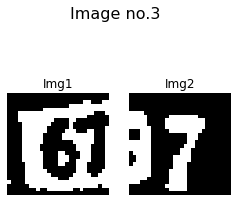

Image no.3
Correct label: 'Different numbers'
3.0060338973999023



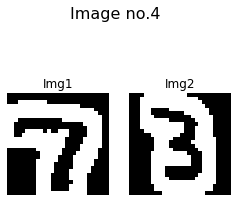

Image no.4
Correct label: 'Different numbers'
2.135692596435547



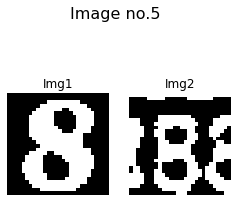

Image no.5
Correct label: 'Same numbers'
0.04355273395776749



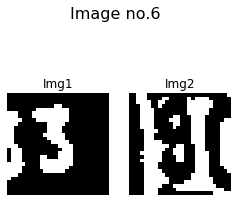

Image no.6
Correct label: 'Different numbers'
1.3876800537109375



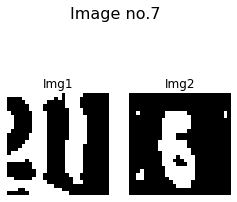

Image no.7
Correct label: 'Different numbers'
2.000983238220215



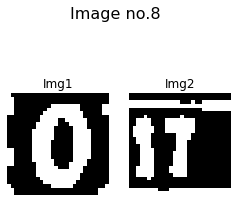

Image no.8
Correct label: 'Different numbers'
2.027561902999878



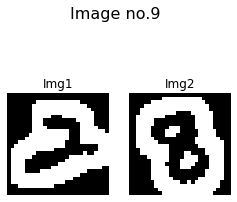

Image no.9
Correct label: 'Different numbers'
2.041112184524536


Images with same number
Mean: 0.35208308696746826
Std: 0.4748857021331787

Images with different number
Mean: 1.9920867681503296
Std: 0.4112919270992279

Accuracy 0.926975


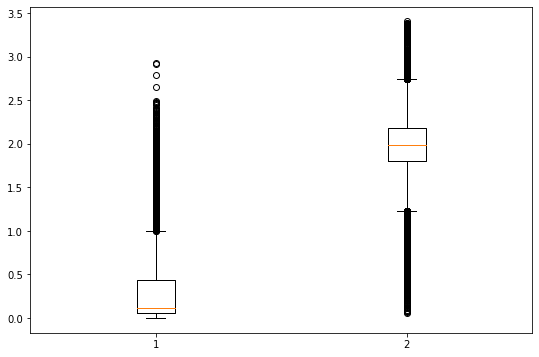

Starting mnist pipeline
Preprocessing MNIST
MNIST preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00192, Train acc 0.89033
Val loss 0.00237, Val acc 0.97879
--EPOCH 2--
Train loss 0.00037, Train acc 0.98567
Val loss 0.00142, Val acc 0.98317
--EPOCH 3--
Train loss 0.00022, Train acc 0.99058
Val loss 0.00098, Val acc 0.98829
--EPOCH 4--
Train loss 0.00019, Train acc 0.99103
Val loss 0.00250, Val acc 0.96533
--EPOCH 5--
Train loss 0.00019, Train acc 0.99119
Val loss 0.00119, Val acc 0.98513
--EPOCH 6--
Train loss 0.00016, Train acc 0.99228
Val loss 0.00151, Val acc 0.98029
--EPOCH 7--
Train loss 0.00017, Train acc 0.99175
Val loss 0.00091, Val acc 0.98950
--EPOCH 8--
Train loss 0.00015, Train acc 0.99303
Val loss 0.00104, Val acc 0.98642
--EPOCH 9--
Train loss 0.00016, Train acc 0.99245
Val loss 0.00141, Val acc 0.98046
--EPOCH 10--
Train loss 0.00013, Train acc 0.99394
Val loss 0.00132, Val acc 0.98137
Saved model with name: fold1-epoch7-transforms9457.pt
--FOLD 2--

--EPOCH 1--
Train 

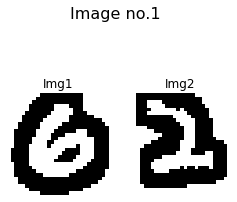

Image no.1
Correct label: 'Different numbers'
2.268500804901123



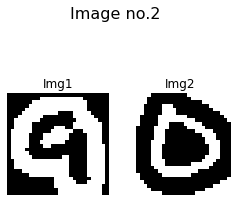

Image no.2
Correct label: 'Different numbers'
2.0149738788604736



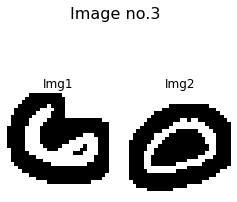

Image no.3
Correct label: 'Different numbers'
2.0058584213256836



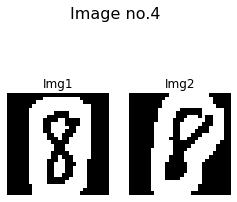

Image no.4
Correct label: 'Same numbers'
0.0441288985311985



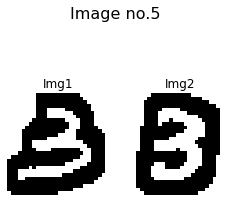

Image no.5
Correct label: 'Same numbers'
0.009415769949555397



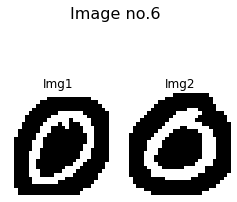

Image no.6
Correct label: 'Same numbers'
0.015942614525556564



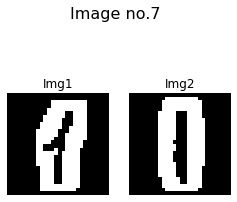

Image no.7
Correct label: 'Same numbers'
0.04522010684013367



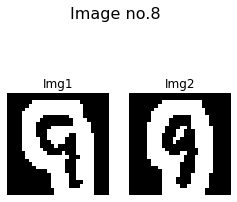

Image no.8
Correct label: 'Same numbers'
0.030396563932299614



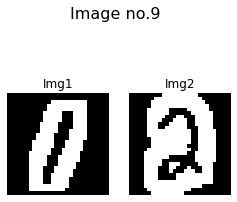

Image no.9
Correct label: 'Different numbers'
2.2994470596313477


Images with same number
Mean: 0.12107956409454346
Std: 0.28236424922943115

Images with different number
Mean: 2.3300082683563232
Std: 0.41999393701553345

Accuracy 0.98335


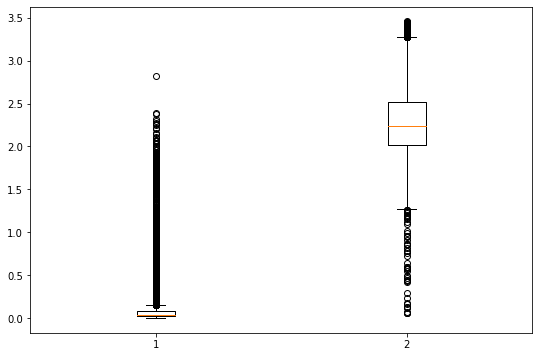

Starting svhn pipeline
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00346, Train acc 0.76880
Val loss 0.00751, Val acc 0.89533
--EPOCH 2--
Train loss 0.00131, Train acc 0.93455
Val loss 0.00478, Val acc 0.93796
--EPOCH 3--
Train loss 0.00082, Train acc 0.96005
Val loss 0.00360, Val acc 0.94879
--EPOCH 4--
Train loss 0.00064, Train acc 0.96762
Val loss 0.00328, Val acc 0.95300
--EPOCH 5--
Train loss 0.00057, Train acc 0.97081
Val loss 0.00325, Val acc 0.95279
--EPOCH 6--
Train loss 0.00051, Train acc 0.97319
Val loss 0.00264, Val acc 0.96467
--EPOCH 7--
Train loss 0.00048, Train acc 0.97554
Val loss 0.00279, Val acc 0.96175
--EPOCH 8--
Train loss 0.00045, Train acc 0.97677
Val loss 0.00306, Val acc 0.95567
--EPOCH 9--
Train loss 0.00043, Train acc 0.97733
Val loss 0.00235, Val acc 0.96962
--EPOCH 10--
Train loss 0.00040, Train acc 0.97926
Val loss 0.00240, Val acc 0.96475
Saved model with name: fold1-e

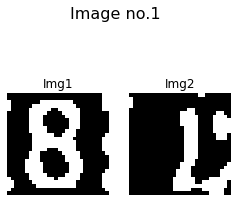

Image no.1
Correct label: 'Different numbers'
1.7624682188034058



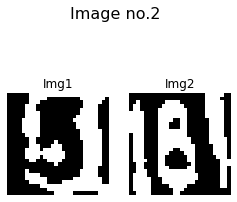

Image no.2
Correct label: 'Different numbers'
2.280954122543335



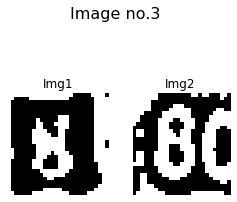

Image no.3
Correct label: 'Same numbers'
0.06051981821656227



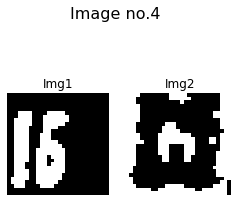

Image no.4
Correct label: 'Same numbers'
0.28903454542160034



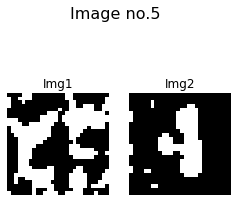

Image no.5
Correct label: 'Same numbers'
0.02546362392604351



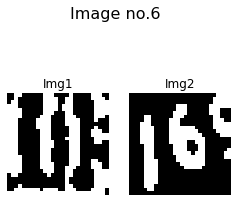

Image no.6
Correct label: 'Different numbers'
1.9535244703292847



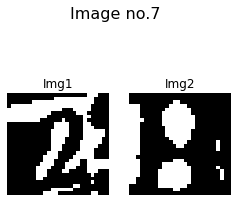

Image no.7
Correct label: 'Same numbers'
0.04947909712791443



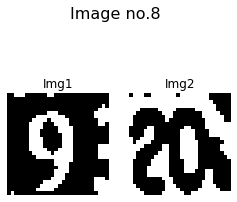

Image no.8
Correct label: 'Different numbers'
1.613121747970581



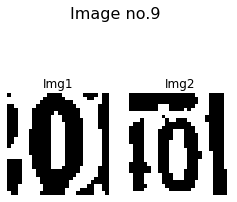

Image no.9
Correct label: 'Same numbers'
0.029225463047623634


Images with same number
Mean: 0.4513750970363617
Std: 0.5889098048210144

Images with different number
Mean: 1.8504220247268677
Std: 0.38500145077705383

Accuracy 0.8825


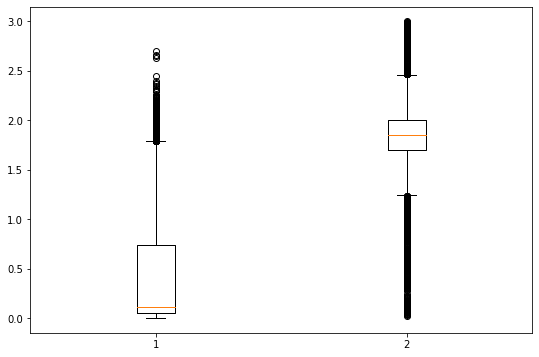

In [25]:
first_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        AdaptiveThreshold(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=True
)

print("Running config 1 pipeline")
first_config.all_pipelines()

Running config 2 pipeline
Starting mnist-svhn-mix pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00149, Train acc 0.81384
Val loss 0.00194, Val acc 0.95046
--EPOCH 2--
Train loss 0.00032, Train acc 0.96639
Val loss 0.00111, Val acc 0.96954
--EPOCH 3--
Train loss 0.00024, Train acc 0.97502
Val loss 0.00105, Val acc 0.97052
--EPOCH 4--
Train loss 0.00021, Train acc 0.97729
Val loss 0.00088, Val acc 0.97615
--EPOCH 5--
Train loss 0.00019, Train acc 0.97857
Val loss 0.00087, Val acc 0.97648
--EPOCH 6--
Train loss 0.00019, Train acc 0.97952
Val loss 0.00092, Val acc 0.97379
--EPOCH 7--
Train loss 0.00018, Train acc 0.98060
Val loss 0.00092, Val acc 0.97369
--EPOCH 8--
Train loss 0.00018, Train acc 0.98016
Val loss 0.00079, Val acc 0.97658
--EPOCH 9--
Train loss 0.00017, Train acc 0.98056
Val loss 0.00086, Val acc 0.97460
--EPOCH 10--
Train loss 0.00016, Train a

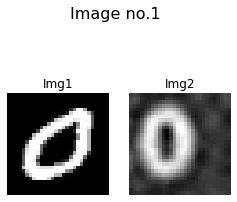

Image no.1
Correct label: 'Same numbers'
0.05225099250674248



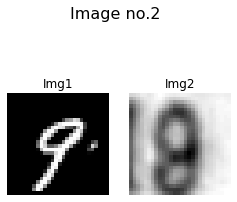

Image no.2
Correct label: 'Same numbers'
0.02373492531478405



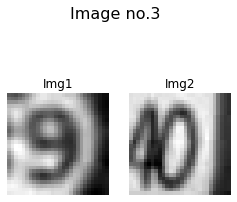

Image no.3
Correct label: 'Different numbers'
1.9420090913772583



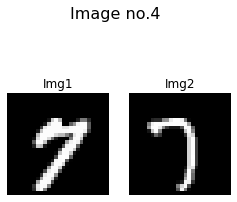

Image no.4
Correct label: 'Same numbers'
0.2686949372291565



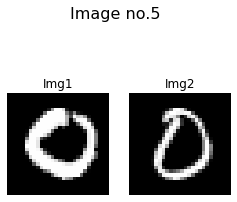

Image no.5
Correct label: 'Same numbers'
0.03413534164428711



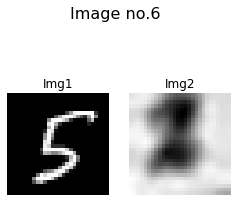

Image no.6
Correct label: 'Different numbers'
1.7934564352035522



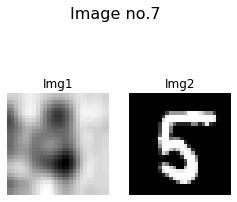

Image no.7
Correct label: 'Different numbers'
2.0629522800445557



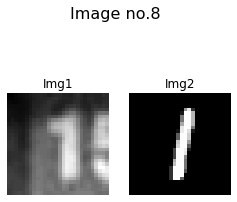

Image no.8
Correct label: 'Same numbers'
0.9104934334754944



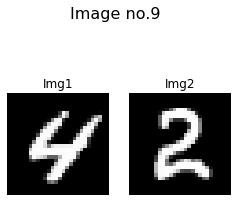

Image no.9
Correct label: 'Different numbers'
2.075885534286499


Images with same number
Mean: 0.2597496211528778
Std: 0.4788542091846466

Images with different number
Mean: 1.9985780715942383
Std: 0.30699557065963745

Accuracy 0.9431


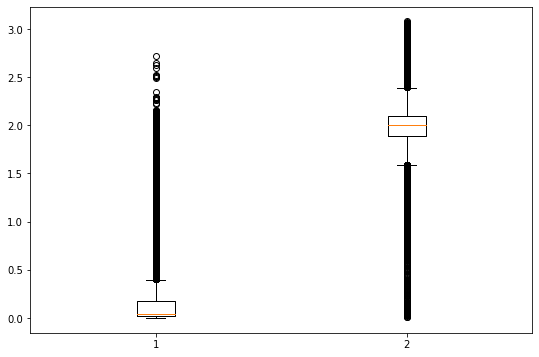

Starting mnist-svhn pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00138, Train acc 0.80717
Val loss 0.00233, Val acc 0.93537
--EPOCH 2--
Train loss 0.00035, Train acc 0.96384
Val loss 0.00122, Val acc 0.96975
--EPOCH 3--
Train loss 0.00025, Train acc 0.97410
Val loss 0.00118, Val acc 0.96767
--EPOCH 4--
Train loss 0.00021, Train acc 0.97737
Val loss 0.00104, Val acc 0.96975
--EPOCH 5--
Train loss 0.00020, Train acc 0.97853
Val loss 0.00104, Val acc 0.97010
--EPOCH 6--
Train loss 0.00019, Train acc 0.98000
Val loss 0.00100, Val acc 0.97179
--EPOCH 7--
Train loss 0.00018, Train acc 0.98061
Val loss 0.00083, Val acc 0.97742
--EPOCH 8--
Train loss 0.00018, Train acc 0.98071
Val loss 0.00099, Val acc 0.97446
--EPOCH 9--
Train loss 0.00017, Train acc 0.98130
Val loss 0.00110, Val acc 0.96721
--EPOCH 10--
Train loss 0.00016, Train acc 0.98255
Val loss 0.00093, V

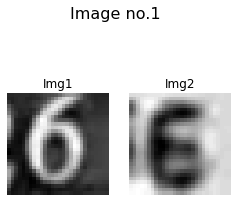

Image no.1
Correct label: 'Same numbers'
0.059042789041996



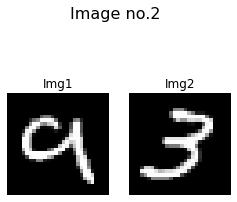

Image no.2
Correct label: 'Different numbers'
2.1147189140319824



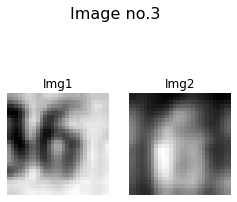

Image no.3
Correct label: 'Same numbers'
0.1096571758389473



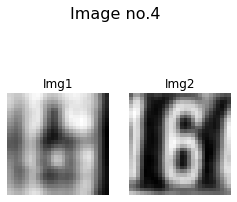

Image no.4
Correct label: 'Same numbers'
0.06087697669863701



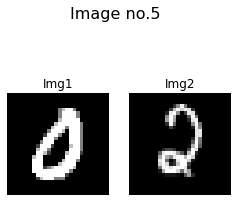

Image no.5
Correct label: 'Different numbers'
1.9178860187530518



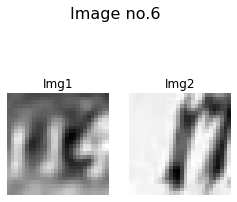

Image no.6
Correct label: 'Same numbers'
0.8869585990905762



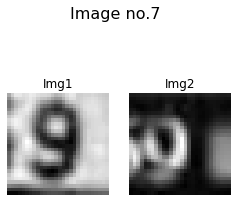

Image no.7
Correct label: 'Same numbers'
2.0101318359375



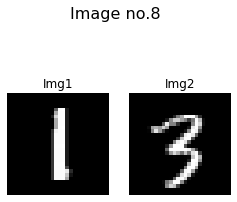

Image no.8
Correct label: 'Different numbers'
2.107046127319336



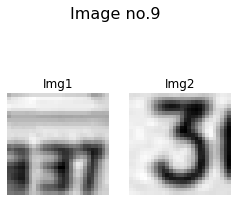

Image no.9
Correct label: 'Same numbers'
1.7760324478149414


Images with same number
Mean: 0.22303350269794464
Std: 0.44333216547966003

Images with different number
Mean: 2.0038812160491943
Std: 0.325216680765152

Accuracy 0.952875


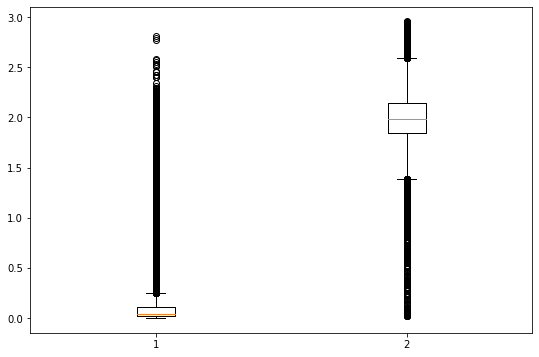

Starting mnist pipeline
Preprocessing MNIST
MNIST preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00155, Train acc 0.93236
Val loss 0.00131, Val acc 0.98696
--EPOCH 2--
Train loss 0.00020, Train acc 0.99200
Val loss 0.00083, Val acc 0.99029
--EPOCH 3--
Train loss 0.00014, Train acc 0.99413
Val loss 0.00109, Val acc 0.98533
--EPOCH 4--
Train loss 0.00013, Train acc 0.99425
Val loss 0.00055, Val acc 0.99454
--EPOCH 5--
Train loss 0.00011, Train acc 0.99491
Val loss 0.00063, Val acc 0.99183
--EPOCH 6--
Train loss 0.00012, Train acc 0.99430
Val loss 0.00085, Val acc 0.98858
--EPOCH 7--
Train loss 0.00010, Train acc 0.99528
Val loss 0.00064, Val acc 0.99158
--EPOCH 8--
Train loss 0.00010, Train acc 0.99514
Val loss 0.00070, Val acc 0.99046
Saved model with name: fold1-epoch4-transforms3213.pt
--FOLD 2--

--EPOCH 1--
Train loss 0.00149, Train acc 0.93553
Val loss 0.00127, Val acc 0.98687
--EPOCH 2--
Train loss 0.00021, Train acc 0.99116
Val loss 0.00099, Val acc 0.98767
--EPOCH 3--
Train l

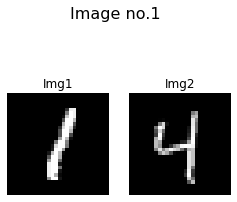

Image no.1
Correct label: 'Different numbers'
2.230283498764038



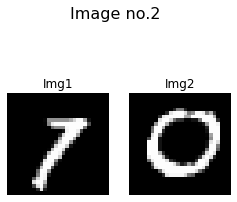

Image no.2
Correct label: 'Different numbers'
1.98404061794281



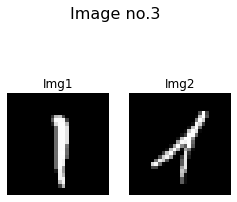

Image no.3
Correct label: 'Same numbers'
0.13225284218788147



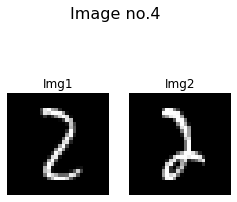

Image no.4
Correct label: 'Same numbers'
0.04292275011539459



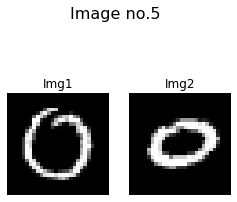

Image no.5
Correct label: 'Same numbers'
0.02280825935304165



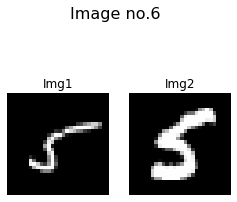

Image no.6
Correct label: 'Same numbers'
0.019324891269207



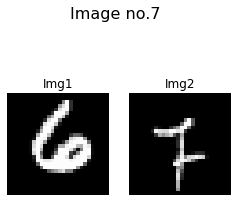

Image no.7
Correct label: 'Different numbers'
2.862311601638794



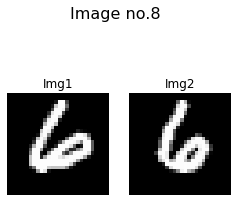

Image no.8
Correct label: 'Same numbers'
0.02577686496078968



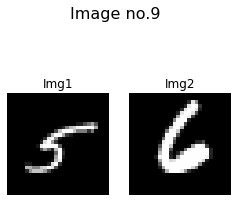

Image no.9
Correct label: 'Different numbers'
2.1528918743133545


Images with same number
Mean: 0.08857730776071548
Std: 0.21268782019615173

Images with different number
Mean: 2.3893702030181885
Std: 0.44127601385116577

Accuracy 0.9918


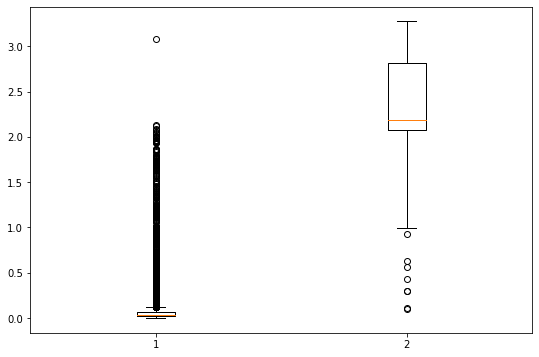

Starting svhn pipeline
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00526, Train acc 0.58547
Val loss 0.01183, Val acc 0.80800
--EPOCH 2--
Train loss 0.00168, Train acc 0.90638
Val loss 0.00464, Val acc 0.94117
--EPOCH 3--
Train loss 0.00073, Train acc 0.96413
Val loss 0.00281, Val acc 0.96321
--EPOCH 4--
Train loss 0.00054, Train acc 0.97193
Val loss 0.00333, Val acc 0.95292
--EPOCH 5--
Train loss 0.00048, Train acc 0.97515
Val loss 0.00232, Val acc 0.96917
--EPOCH 6--
Train loss 0.00044, Train acc 0.97707
Val loss 0.00227, Val acc 0.96671
--EPOCH 7--
Train loss 0.00040, Train acc 0.97957
Val loss 0.00261, Val acc 0.96354
--EPOCH 8--
Train loss 0.00038, Train acc 0.97997
Val loss 0.00183, Val acc 0.97558
--EPOCH 9--
Train loss 0.00037, Train acc 0.98025
Val loss 0.00311, Val acc 0.95183
--EPOCH 10--
Train loss 0.00034, Train acc 0.98210
Val loss 0.00188, Val acc 0.97150
Saved model with name: fold1-e

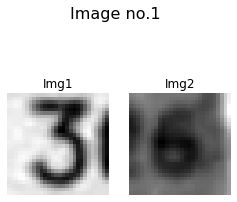

Image no.1
Correct label: 'Different numbers'
2.612671375274658



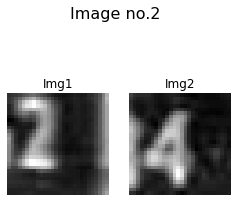

Image no.2
Correct label: 'Different numbers'
1.9015835523605347



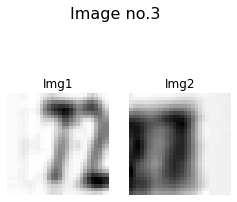

Image no.3
Correct label: 'Same numbers'
0.10407574474811554



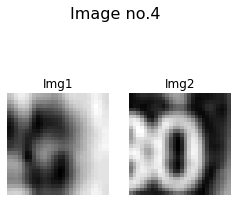

Image no.4
Correct label: 'Same numbers'
0.29028192162513733



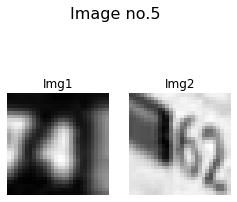

Image no.5
Correct label: 'Different numbers'
1.7748429775238037



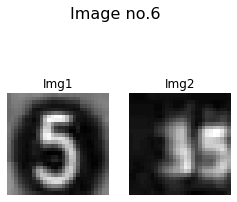

Image no.6
Correct label: 'Different numbers'
1.8656941652297974



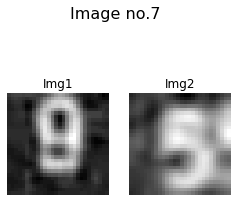

Image no.7
Correct label: 'Different numbers'
1.8965595960617065



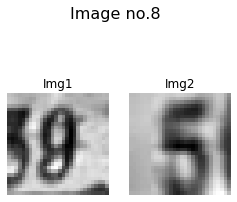

Image no.8
Correct label: 'Different numbers'
2.0237841606140137



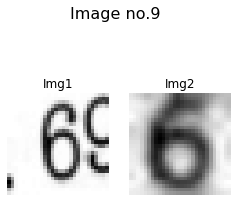

Image no.9
Correct label: 'Same numbers'
0.023545291274785995


Images with same number
Mean: 0.36612725257873535
Std: 0.5763986706733704

Images with different number
Mean: 2.0106122493743896
Std: 0.4386482238769531

Accuracy 0.91535


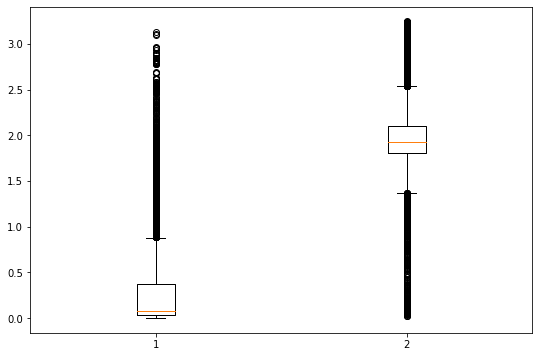

In [26]:
second_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        EqualizeHist(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=True
)

print("Running config 2 pipeline")
second_config.all_pipelines()

Running config 3 pipeline
Starting mnist-svhn-mix pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00145, Train acc 0.81591
Val loss 0.00474, Val acc 0.85560
--EPOCH 2--
Train loss 0.00053, Train acc 0.94268
Val loss 0.00221, Val acc 0.94383
--EPOCH 3--
Train loss 0.00035, Train acc 0.96815
Val loss 0.00190, Val acc 0.95552
--EPOCH 4--
Train loss 0.00032, Train acc 0.97007
Val loss 0.00201, Val acc 0.94665
--EPOCH 5--
Train loss 0.00029, Train acc 0.97268
Val loss 0.00156, Val acc 0.95925
--EPOCH 6--
Train loss 0.00028, Train acc 0.97335
Val loss 0.00186, Val acc 0.94967
--EPOCH 7--
Train loss 0.00026, Train acc 0.97472
Val loss 0.00148, Val acc 0.96067
--EPOCH 8--
Train loss 0.00025, Train acc 0.97568
Val loss 0.00173, Val acc 0.95627
--EPOCH 9--
Train loss 0.00025, Train acc 0.97580
Val loss 0.00223, Val acc 0.93929
--EPOCH 10--
Train loss 0.00024, Train a

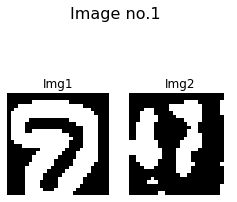

Image no.1
Correct label: 'Same numbers'
0.10843788832426071



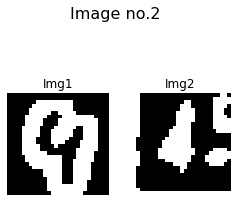

Image no.2
Correct label: 'Same numbers'
0.12561774253845215



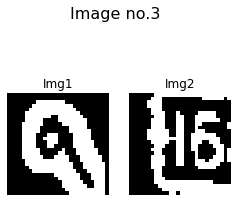

Image no.3
Correct label: 'Different numbers'
1.8688629865646362



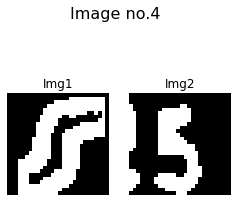

Image no.4
Correct label: 'Same numbers'
0.09402170032262802



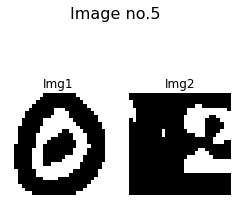

Image no.5
Correct label: 'Different numbers'
1.6397216320037842



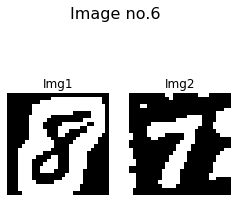

Image no.6
Correct label: 'Different numbers'
2.5792973041534424



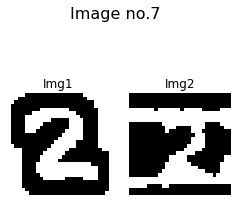

Image no.7
Correct label: 'Same numbers'
0.27949032187461853



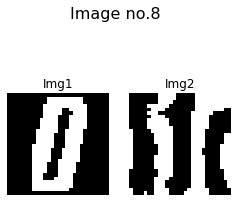

Image no.8
Correct label: 'Same numbers'
0.07111169397830963



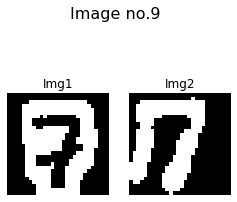

Image no.9
Correct label: 'Same numbers'
0.25213930010795593


Images with same number
Mean: 0.39603176712989807
Std: 0.5051013827323914

Images with different number
Mean: 1.7181390523910522
Std: 0.544502854347229

Accuracy 0.8821464253996447


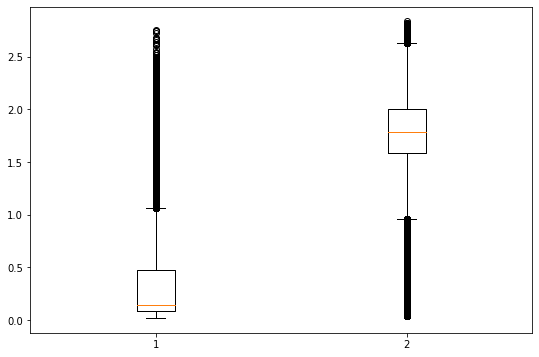

In [27]:
third_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        AdaptiveThreshold(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=False
)

print("Running config 3 pipeline")
third_config.mnist_svhn_mix_pipeline()

Running config 4 pipeline
Starting mnist-svhn-mix pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00188, Train acc 0.73873
Val loss 0.00979, Val acc 0.62350
--EPOCH 2--
Train loss 0.00117, Train acc 0.84948
Val loss 0.00381, Val acc 0.89387
--EPOCH 3--
Train loss 0.00040, Train acc 0.96042
Val loss 0.00184, Val acc 0.95713
--EPOCH 4--
Train loss 0.00029, Train acc 0.97418
Val loss 0.00164, Val acc 0.96606
--EPOCH 5--
Train loss 0.00025, Train acc 0.97757
Val loss 0.00256, Val acc 0.93852
--EPOCH 6--
Train loss 0.00023, Train acc 0.97883
Val loss 0.00131, Val acc 0.97192
--EPOCH 7--
Train loss 0.00022, Train acc 0.97917
Val loss 0.00216, Val acc 0.94854
--EPOCH 8--
Train loss 0.00020, Train acc 0.98092
Val loss 0.00168, Val acc 0.95473
--EPOCH 9--
Train loss 0.00020, Train acc 0.98097
Val loss 0.00174, Val acc 0.95679
--EPOCH 10--
Train loss 0.00019, Train a

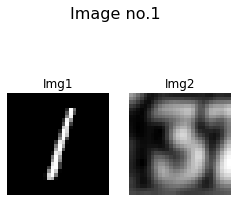

Image no.1
Correct label: 'Different numbers'
1.9822578430175781



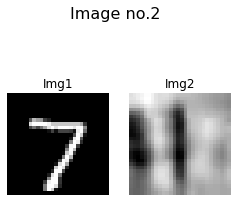

Image no.2
Correct label: 'Different numbers'
1.5002392530441284



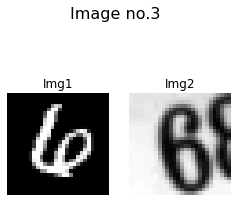

Image no.3
Correct label: 'Same numbers'
0.1428307294845581



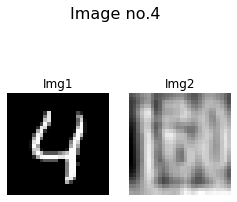

Image no.4
Correct label: 'Different numbers'
1.8607710599899292



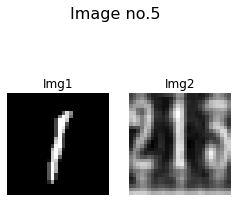

Image no.5
Correct label: 'Same numbers'
0.1558576226234436



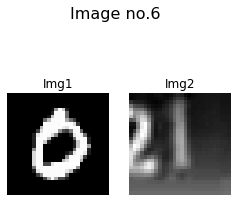

Image no.6
Correct label: 'Different numbers'
1.7625384330749512



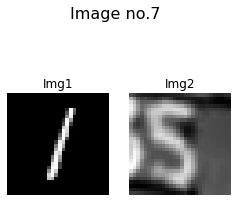

Image no.7
Correct label: 'Different numbers'
1.8845953941345215



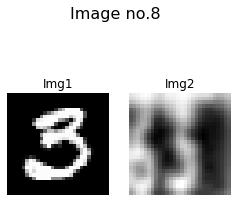

Image no.8
Correct label: 'Same numbers'
0.2135908305644989



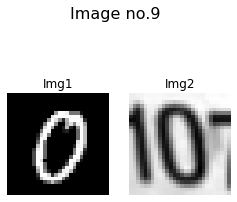

Image no.9
Correct label: 'Same numbers'
0.056032322347164154


Images with same number
Mean: 0.3189588189125061
Std: 0.39178600907325745

Images with different number
Mean: 1.7050611972808838
Std: 0.5232282876968384

Accuracy 0.9131188943161634


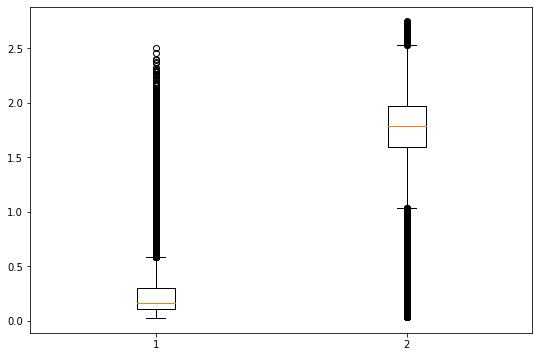

In [28]:
forth_pipeline = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        EqualizeHist(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=False
)

print("Running config 4 pipeline")
forth_pipeline.mnist_svhn_mix_pipeline()

### Siamese model

|      EqualizeHist   |                  |  |             |            |   Adaptive Threshold             |                |  |         |         |
|----------------|------------------|--------------|-------------|------------|----------------|----------------|--------------------|---------|---------|
| Metrics        | SVHN-MNIST MIX   | SVHN-MNIST   | MNIST       | SVHN       | Metrics        | SVHN-MNIST MIX | SVHN-MNIST         | MNIST   | SVHN    |
| Accuracy       | 0.94310          | 0.952875     | ***0.99180***      | 0.91535    | Accuracy       | 0.93328        | 0.92698            | 0.98335 | 0.88250 |
| Similiar Mean  | 0.25974       | 0.22303  | **0.08857** | 0.36612 | Similiar Mean  | 0.28782        | 0.35208            | 0.12108 | 0.45138 |
| Similiar std   | 0.47885       | 0.44333  | **0.21268**  | 0.57639 | Similiar std   | 0.52744        | 0.47489            | 0.28236 | 0.58891 |
| Different mean | ***1.99857*** | 2.00388  | 2.38937 | 2.01061 | Different mean | 1.99581        | 1.99209            | 2.33001 | 1.85042 |
| Different std  | **0.30699**  | 0.32521  | 0.44127 | 0.43864 | Different std  | 0.39623        | 0.41129            | 0.41999 | 0.38500 |


### Non-Siamese model

| EqualizeHist   |                | Adaptive Threshold |                |
|----------------|----------------|--------------------|----------------|
| Metrics        | SVHN-MNIST MIX | Metrics            | SVHN-MNIST MIX |
| Accuracy       | 0.91312        | Accuracy           | 0.88215        |
| Similar Mean  | 0.31896        | Similar Mean      | 0.39603        |
| Similar std   | 0.39179        | Similar std       | 0.50510        |
| Different mean | 1.70506        | Different mean     | 1.71814        |
| Different std  | 0.52323        | Different std      | 0.54450        |


From the results we can read that the siamese model achieves better accuracy on the SVHN-MNIST-mix with both preprocessings.
We can also see that the siamese model achieves the highest accuracy when only working on the MNIST dataset. In addition the model performs better on every trial with the EqualizeHistogram preprocessing compared to the adaptive threshold. Last we see that the SVHN-MNIST achieves better results than the SVHN trial alone.